In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
from NN_Models import *
import json
import numpy as np
from preprocessing import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# X_train = torch.load('data/X_author_train.pt')
# y_train = torch.load('data/y_train.pt')

# # X_train = torch.load('data/X_author_all.pt')
# # y_train = torch.load('data/y_all.pt')

# X_test = torch.load('data/X_author_test.pt')
# y_test = torch.load('data/y_test.pt')

In [3]:
X_sentence = torch.load('data/X_sentence_all.pt')
X_year_venue = torch.load('data/X_year_venue_all.pt')
X_coauthor = torch.load('data/X_author_all.pt')

y_all = torch.load('data/y_all.pt')
X_train_data = torch.concat((X_sentence, X_coauthor), axis=1)

In [4]:
y_all

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [5]:
kaggle_coauthor = for_kaggle('coauthor')
kaggle_sentence = for_kaggle('word')
kaggle_year_venue = for_kaggle('year_venue')

year: 100%|██████████| 800/800 [00:00<00:00, 66306.55it/s]


In [6]:
mask = [True for _ in range(X_train_data.shape[0])]

X_kaggle_data = torch.concat((kaggle_sentence, kaggle_coauthor), axis=1)

X = torch.concat((X_train_data, X_kaggle_data), axis=0)
# y = torch.concat(())
y_kaggle = torch.zeros([kaggle_coauthor.shape[0], 100])
for _ in range(y_kaggle.shape[0]):
    mask.append(False)
    
mask = torch.tensor(mask)
y = torch.concat((y_all, y_kaggle), axis=0)

print(X.shape)
print(y.shape)

torch.Size([10154, 26145])
torch.Size([10154, 100])


In [7]:
len(mask)

10154

In [8]:
from itertools import combinations

edges = []
edge_dict = {}

link_matrix = torch.concat((X_year_venue, kaggle_year_venue), axis=0)[:, :465]
# link_matrix = torch.concat((X_coauthor, kaggle_coauthor), axis=0)

print(link_matrix.shape)

for j in tqdm(range(link_matrix.shape[1])):
    col = []
    for i in range(link_matrix.shape[0]):
        if link_matrix[i, j] == 1:
            col.append(i)
    
    for i, j in combinations(col, 2):
        # if [i, j] not in edges:
        #     edges.append([i, j])
        edge_dict[f"{i},{j}"] = 1
            
for pair in tqdm(edge_dict.keys(), total=len(edge_dict.keys())):
    p = pair.split(',')
    edges.append([int(p[0]), int(p[1])])

edges = torch.tensor(np.array(edges).T)
print(edges.shape)

torch.Size([10154, 465])


100%|██████████| 1294085/1294085 [00:03<00:00, 389377.57it/s]


torch.Size([2, 1294085])


In [9]:
# torch.save(edges, 'data/edges.pt')

# edges = torch.load('data/edges.pt')
edges

tensor([[ 101,  101,  101,  ..., 9366, 9555, 9484],
        [ 153,  254,  274,  ..., 9656, 9656, 9693]])

In [10]:
model = GraphNeuralNetwork()
model.fit(X, edges, y, mask)

In [11]:
model.train(epochs=10)

100%|██████████| 10/10 [28:40<00:00, 172.10s/it]


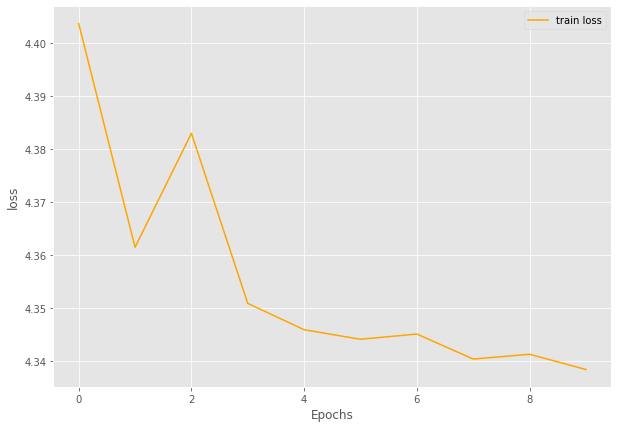

In [12]:
model.plot_loss()

In [13]:
import random

test_mask = [False for i in range(X.shape[0])]
n = [i for i in range(X_coauthor.shape[0])]
index = random.sample(n, k=800)
for i in index:
    test_mask[i] = True

In [14]:
# logits = model.model(X_test, edges)
# edges.shape

# logits = model.model(X, edges)[0][~mask]
logits = model.model(X, edges)[0][test_mask]

In [15]:
logits.shape

torch.Size([800, 100])

In [16]:
y_test = y[test_mask]
y_test.shape

torch.Size([800, 100])

In [17]:
def get_author(matrix, threshold):
    result = []
    for i in tqdm(range(matrix.shape[0])):
        au = ""
        for j in range(100):
            if matrix[i, j] >= threshold:
                au += str(j) + " "
        if au:
            result.append(au[:-1])
        else:
            result.append("-1")
    return result

In [18]:
test_list = get_author(y_test, threshold=1)

100%|██████████| 800/800 [00:00<00:00, 1120.75it/s]


In [28]:
threshold = 0.9
pred_list = get_author(logits, threshold=threshold)

100%|██████████| 800/800 [00:00<00:00, 829.31it/s]


In [29]:
from evaluation import print_scores

print_scores(test_list, pred_list)

=========================Evaluation results=========================
The accuracy score of prediction is : 0.0
The recall   score of prediction is : 0.0
The f1       score of prediction is : 0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
test_list[8]

'71 82'

In [24]:
logits[8][82]

tensor(0.1804, grad_fn=<SelectBackward0>)

In [25]:
for i in range(100):
    if logits[8][i] > 0.99:
        print(i)

In [26]:
# logits[:, 26]

In [27]:
pred_list

['-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',